In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')

In [3]:
import project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import time


# Code to randomly subset 1 million rows 

## Download latest version
#import kagglehub
#path = kagglehub.dataset_download("dilwong/flightprices")
#print("Path to dataset files:", path)

#csv_file = 'itineraries.csv'
#filename = os.path.join(path, csv_file)

## Set sample size
#sample_size = 1_000_000

## Set random seed
#random.seed(12345)

## Total number of rows in the file (including header)
#with open(filename) as f:
    #total_rows = sum(1 for _ in f)

## Generate rows to skip (excluding the header)
#if sample_size < total_rows - 1:
    #skip = sorted(random.sample(range(1, total_rows), total_rows - sample_size))
#else:
    #skip = []

## Read a sample of the data
#df = pd.read_csv(filename, skiprows=skip)

## Drop rows with missing values
#df.dropna(inplace=True)

## Preview the data
#print(df.tail())

df = pd.read_csv('/content/drive/MyDrive/flight_data_sampled.csv')
df.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,8a6ab300fc0b1f1aa1da065091f878fb,2022-04-16,2022-04-17,ATL,CLT,VAA0JKEN,PT4H23M,0,False,False,...,1650194280||1650203580,2022-04-17T07:18:00.000-04:00||2022-04-17T09:5...,IAD||CLT,ATL||IAD,United||United,UA||UA,Airbus A319||Embraer 175 (Enhanced Winglets),6480||5580,541||327,coach||coach
1,43965f64f3fd79750aebb16dc9c96dd0,2022-04-16,2022-04-17,ATL,DEN,VAA0AKEN,PT6H42M,0,False,False,...,1650194280||1650211920,2022-04-17T07:18:00.000-04:00||2022-04-17T10:1...,IAD||DEN,ATL||IAD,United||United,UA||UA,Airbus A319||Boeing 757-200,6480||14100,541||1473,coach||coach
2,ce824fe4eea70d2310b0f01559b52575,2022-04-16,2022-04-17,ATL,DTW,QAA0OFEN,PT5H44M,0,False,False,...,1650239580||1650253020,2022-04-17T18:53:00.000-05:00||2022-04-17T23:3...,ORD||DTW,ATL||ORD,United||United,UA||UA,Airbus A320||Embraer 175 (Enhanced Winglets),7200||5220,600||240,coach||coach
3,81ac082d58bdc39bd60bb9ef290c0693,2022-04-16,2022-04-17,ATL,ORD,V0AHZNN1,PT2H15M,0,False,False,...,1650228840,2022-04-17T15:54:00.000-05:00,ORD,ATL,American Airlines,AA,Embraer 175,8100,600,coach
4,3d02a2206641557ce8a72b5af896893a,2022-04-16,2022-04-17,ATL,SFO,MA0QA0MQ,PT5H19M,0,False,False,...,1650256440,2022-04-17T21:34:00.000-07:00,SFO,ATL,Delta,DL,Airbus A330-200,19140,2135,coach


## Data Cleaning and Preprocessing

In [4]:
# Convert any date columns into datetime
df['travelDuration'] = df['travelDuration'].apply(project.iso_to_hours)
df.dropna(subset=['travelDuration'], inplace=True)

df = df.drop(['legId', 'fareBasisCode', 'baseFare',
              'segmentsAirlineCode', 'segmentsDepartureTimeEpochSeconds',
              'segmentsArrivalTimeEpochSeconds', 'segmentsDurationInSeconds',
              'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode'], axis=1)

# Take first values for departure columns
df['segmentsDepartureTimeRaw'] = df['segmentsDepartureTimeRaw'].str.extract(r'^([^|]+)')
df['segmentsAirlineName'] = df['segmentsAirlineName'].str.extract(r'^([^|]+)')
df['segmentsCabinCode'] = df['segmentsCabinCode'].str.extract(r'^([^|]+)')

#Take  last values for arrival columns
df['segmentsArrivalTimeRaw'] = df['segmentsArrivalTimeRaw'].str.extract(r'([^|]+)$')


# Take the first equipment type
df['segmentsEquipmentDescription'] = df['segmentsEquipmentDescription'].str.extract(r'^([^|]+)')

# Convert any date columns into datetime
df['searchDate'] = pd.to_datetime(df['searchDate'])
df['flightDate'] = pd.to_datetime(df['flightDate'])
df['segmentsDepartureTimeRaw'] = df['segmentsDepartureTimeRaw'].str[:-6]  # remove timezone info
df['segmentsArrivalTimeRaw'] = df['segmentsArrivalTimeRaw'].str[:-6]  # remove timezone info
df['segmentsDepartureTimeRaw'] = pd.to_datetime(df['segmentsDepartureTimeRaw'])
df['segmentsArrivalTimeRaw'] = pd.to_datetime(df['segmentsArrivalTimeRaw'])


In [5]:
# Cycle Encoding for dates
# Day of Week (0=Monday, 6=Sunday)

df['search_dow_sin'] = np.sin(2 * np.pi * df['searchDate'].dt.dayofweek / 7)
df['search_dow_cos'] = np.cos(2 * np.pi * df['searchDate'].dt.dayofweek / 7)
#df['flight_dow_sin'] = np.sin(2 * np.pi * df['flightDate'].dt.dayofweek / 7)
#df['flight_dow_cos'] = np.cos(2 * np.pi * df['flightDate'].dt.dayofweek / 7)
df['depart_dow_sin'] = np.sin(2 * np.pi * df['segmentsDepartureTimeRaw'].dt.dayofweek / 7)
df['depart_dow_cos'] = np.cos(2 * np.pi * df['segmentsDepartureTimeRaw'].dt.dayofweek / 7)
df['arrival_dow_sin'] = np.sin(2 * np.pi * df['segmentsArrivalTimeRaw'].dt.dayofweek / 7)
df['arrival_dow_cos'] = np.cos(2 * np.pi * df['segmentsArrivalTimeRaw'].dt.dayofweek / 7)

# Month (1=Jan, 12=Dec)
df['search_month_sin'] = np.sin(2 * np.pi * df['searchDate'].dt.month / 12)
df['search_month_cos'] = np.cos(2 * np.pi * df['searchDate'].dt.month / 12)
#df['flight_month_sin'] = np.sin(2 * np.pi * df['flightDate'].dt.month / 12)
#df['flight_month_cos'] = np.cos(2 * np.pi * df['flightDate'].dt.month / 12)
df['depart_month_sin'] = np.sin(2 * np.pi * df['segmentsDepartureTimeRaw'].dt.month / 12)
df['depart_month_cos'] = np.cos(2 * np.pi * df['segmentsDepartureTimeRaw'].dt.month / 12)
df['arrival_month_sin'] = np.sin(2 * np.pi * df['segmentsArrivalTimeRaw'].dt.month / 12)
df['arrival_month_cos'] = np.cos(2 * np.pi * df['segmentsArrivalTimeRaw'].dt.month / 12)

In [6]:
# Number of days in advance
df["daysInAdvance"] = df["flightDate"] - df["searchDate"]
df["daysInAdvance"] = df["daysInAdvance"].dt.total_seconds()

# Count the number of stops a flight makes
df["numStops"] = df['segmentsDistance'].str.count(r'\|\|')
df = df.drop(columns = ['segmentsDistance'])

# Does flight depart between 10PM to 2AM (red-eye hours)?
df['isRedEyeFlight'] = df['segmentsDepartureTimeRaw'].apply(project.red_eye)


# Does the flight depart on a US Federal Holiday?
from pandas.tseries.holiday import USFederalHolidayCalendar
us_cal = USFederalHolidayCalendar()
min_date = min(df["flightDate"])
max_date = max(df["flightDate"])
us_fed_holidays = us_cal.holidays(min(df["flightDate"]), max(df["flightDate"]))
df["departsOnHoliday"] = df["flightDate"].isin(us_fed_holidays)

# Does the flight depart 3 days before a US Federal Holiday?
three_days_before_holiday_dates = project.get_three_days_before_holiday_dates(us_fed_holidays)
three_days_before_holiday_dates = (three_days_before_holiday_dates[1]| three_days_before_holiday_dates[2]| three_days_before_holiday_dates[3])
df["departsThreeDaysBeforeHoliday"] = df["flightDate"].isin(three_days_before_holiday_dates)

# Season flight departs in
df["departureSeason"] = df["flightDate"].apply(project.season)


In [7]:
# Count the number of flights that have taken route from start date to end date
flight_route_count = df.groupby(["startingAirport", "destinationAirport"]).size()
flight_route_count = flight_route_count.reset_index()
flight_route_count = flight_route_count.rename(columns = {0: "flightRouteCount"})
df = pd.merge(df, flight_route_count, on = ["startingAirport", "destinationAirport"])

# Count the number of flights on the same route that day
flights_on_route_same_day = df.groupby(["flightDate", "startingAirport", "destinationAirport"]).size()
flights_on_route_same_day = flights_on_route_same_day.reset_index()
flights_on_route_same_day = flights_on_route_same_day.rename(columns = {0: "flightsOnRouteSameDay"})
df = pd.merge(df, flights_on_route_same_day, on = ["flightDate","startingAirport", "destinationAirport"])

# Count the number of flights per airline
flights_per_airline =  df.groupby(["segmentsAirlineName"]).size()
flights_per_airline = flights_per_airline.reset_index()
flights_per_airline = flights_per_airline.rename(columns = {0: "flightsPerAirlineCount"})
df = pd.merge(df, flights_per_airline, on = ["segmentsAirlineName"])

# Count the number of flights on same route on same day per airline
flights_per_airline_on_route_sd = df.groupby(["segmentsAirlineName", "startingAirport", "destinationAirport", "flightDate"]).size()
flights_per_airline_on_route_sd = flights_per_airline_on_route_sd.reset_index()
flights_per_airline_on_route_sd = flights_per_airline_on_route_sd.rename(columns = {0: "flightsPerAirlineOnRouteSdCount"})
df = pd.merge(df, flights_per_airline_on_route_sd, on = ["segmentsAirlineName", "startingAirport", "destinationAirport", "flightDate"])

# Drop unecessary columns
df = df.drop(columns = ['searchDate', 'isNonStop','segmentsDepartureTimeRaw', 'segmentsArrivalTimeRaw'])

In [8]:
time_data = ['search_dow_sin', 'search_dow_cos', 'search_month_sin', 'search_month_cos',
        'depart_dow_sin','depart_dow_cos', 'depart_month_sin', 'depart_month_cos',
        'arrival_dow_sin', 'arrival_dow_cos', 'arrival_month_sin', 'arrival_month_cos']

# Extract numerical features names
num_features = df.select_dtypes(include=['number']).columns.to_list()
num_features = [col for col in num_features if col not in time_data]
num_features = [col for col in num_features if col != 'totalFare']


In [9]:
# Encode categorical features
from sklearn.preprocessing import OneHotEncoder
cat_features = df.select_dtypes(include=['object', 'string', 'bool']).columns.to_list()
df_encoded = pd.get_dummies(df, columns = cat_features, drop_first = True)

# Extract categorical and time features names
df_encoded_cols = df_encoded.columns.to_list()
cat_features_encoded = [col for col in df_encoded_cols if col not in cat_features]
cat_time = cat_features_encoded + time_data
cat_time_features = [col for col in cat_time if col not in ["flightDate", "totalFare"]]


df_encoded = project.remove_outliers(df_encoded)
df_encoded = df_encoded.dropna()



Number of outliers detected: 12479
Outlier fare threshold: < -187.16 or > 854.88
Number of entries after removing outliers: 896833


## Explanatory Analysis

Flight date range: 2022-04-17 00:00:00 to 2022-11-19 00:00:00


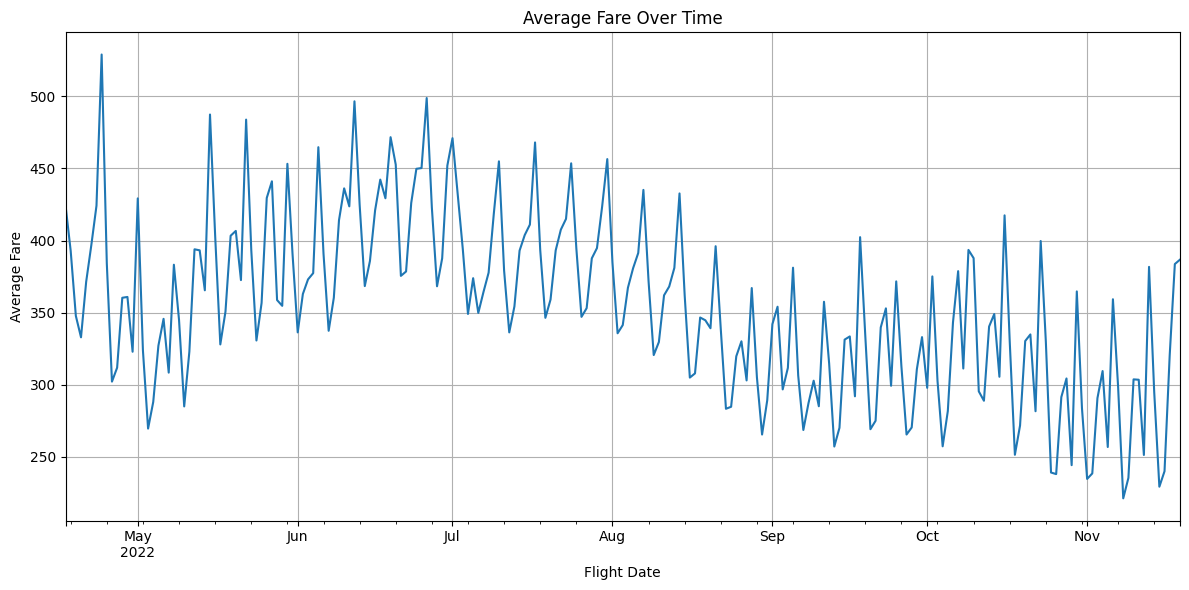

In [10]:
# Average fare by flight date
print(f"Flight date range: {df['flightDate'].min()} to {df['flightDate'].max()}")
plt.figure(figsize=(12,6))
df.groupby('flightDate')['totalFare'].mean().plot()
plt.title('Average Fare Over Time')
plt.xlabel('Flight Date')
plt.ylabel('Average Fare')
plt.grid(True)
plt.tight_layout()
plt.show()

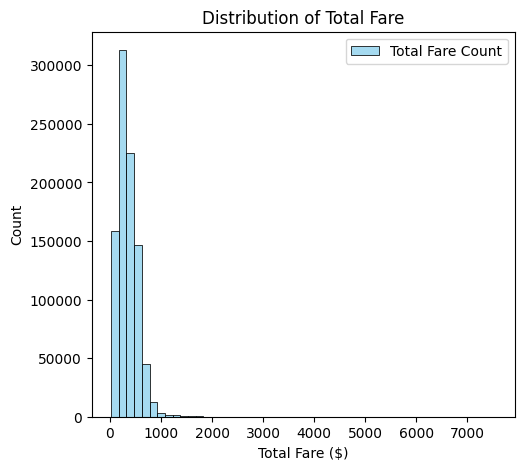

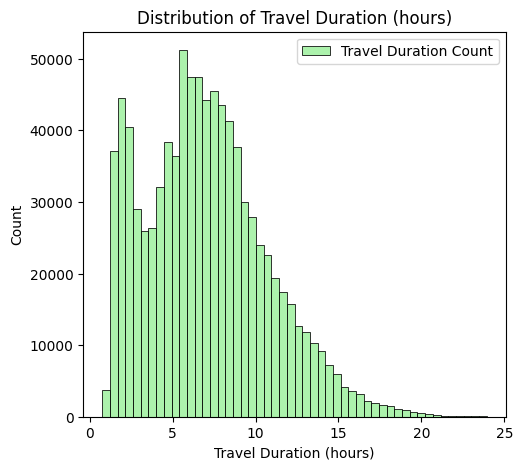

In [11]:
# Distribution plots for Total Fare and Travel Duration
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['totalFare'], bins=50, color='skyblue', label='Total Fare Count')
plt.title('Distribution of Total Fare')
plt.xlabel('Total Fare ($)')
plt.ylabel('Count')
plt.legend()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['travelDuration'], bins=50, color='lightgreen', label='Travel Duration Count')
plt.title('Distribution of Travel Duration (hours)')
plt.xlabel('Travel Duration (hours)')
plt.ylabel('Count')
plt.legend()

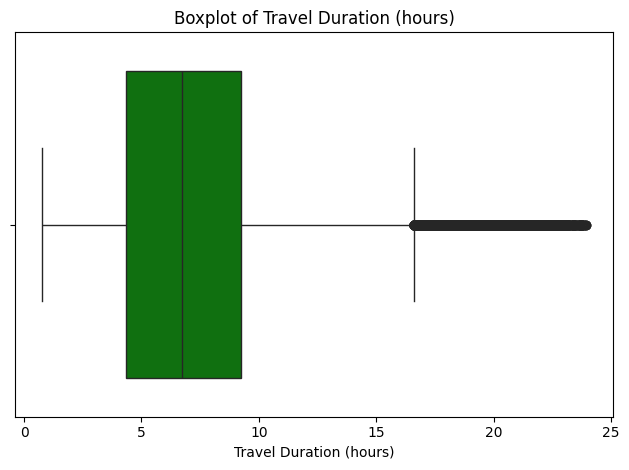

In [19]:
# Boxplot for Travel Duration
sns.boxplot(x=df['travelDuration'], color='green')
plt.title('Boxplot of Travel Duration (hours)')
plt.xlabel('Travel Duration (hours)')
plt.tight_layout()
plt.show()



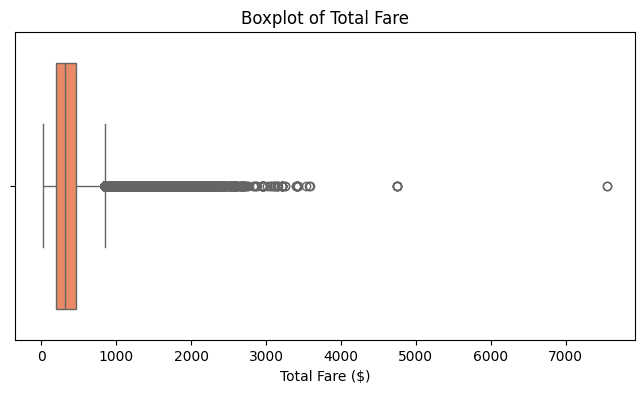

In [20]:
# Boxplot of Total Fare
plt.figure(figsize=(8,4))
sns.boxplot(x=df['totalFare'], color='coral')
plt.title('Boxplot of Total Fare')
plt.xlabel('Total Fare ($)')
plt.show()

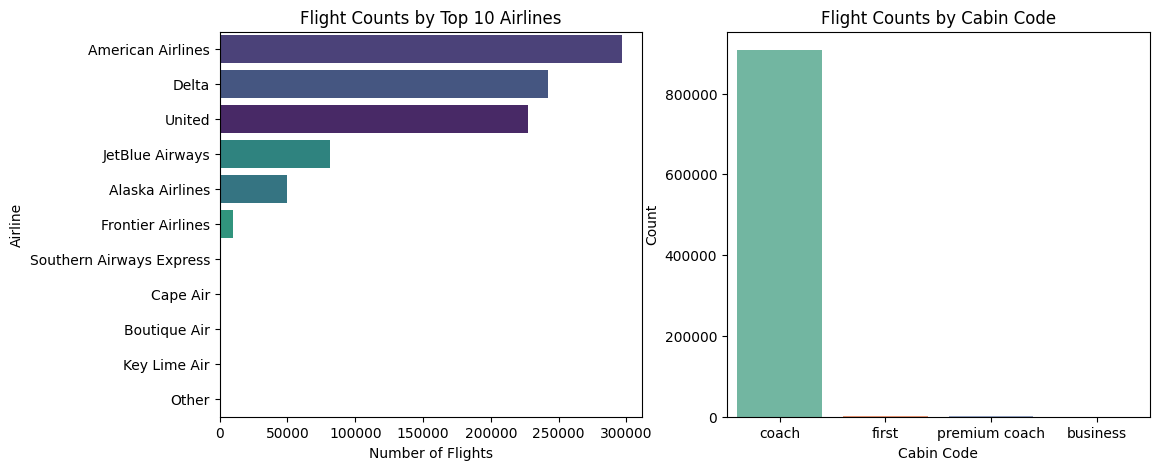

In [21]:
# Count plots for categorical variables
top_airlines = df['segmentsAirlineName'].value_counts().nlargest(10).index
df['airline_top10'] = df['segmentsAirlineName'].where(df['segmentsAirlineName'].isin(top_airlines), other='Other')
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(y='airline_top10',data=df,order=df['airline_top10'].value_counts().index,hue='airline_top10',
              palette='viridis',legend=False)

plt.title('Flight Counts by Top 10 Airlines')
plt.xlabel('Number of Flights')
plt.ylabel('Airline')

plt.subplot(1,2,2)
sns.countplot(x='segmentsCabinCode',data=df,hue='segmentsCabinCode',palette='Set2',legend=False)
plt.title('Flight Counts by Cabin Code')
plt.xlabel('Cabin Code')
plt.ylabel('Count')
plt.show()


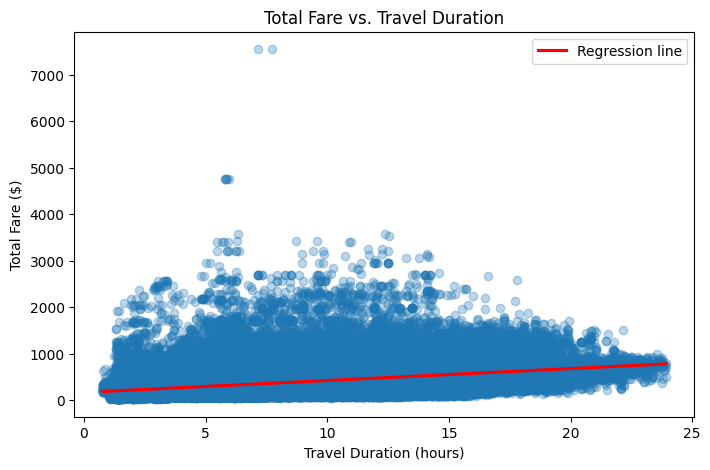

In [22]:
# Scatter plot with regression line: Total Fare vs Travel Duration
plt.figure(figsize=(8,5))
sns.regplot(x='travelDuration', y='totalFare', data=df, scatter_kws={'alpha':0.3, 'label': 'Data points'}, line_kws={'color':'red', 'label': 'Regression line'})
plt.title('Total Fare vs. Travel Duration')
plt.xlabel('Travel Duration (hours)')
plt.ylabel('Total Fare ($)')
plt.legend()
plt.show()


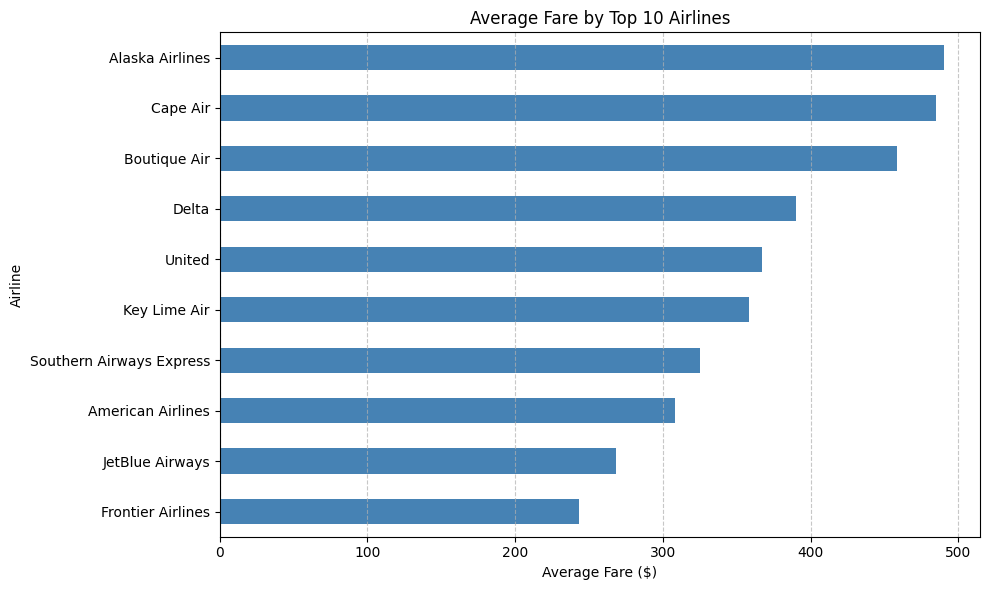

In [23]:
# Average fare by airline bar plot
avg_fares = df.groupby('segmentsAirlineName')['totalFare'].mean().loc[top_airlines].sort_values()
plt.figure(figsize=(10,6))
avg_fares.plot(kind='barh', color='steelblue')
plt.title('Average Fare by Top 10 Airlines')
plt.xlabel('Average Fare ($)')
plt.ylabel('Airline')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

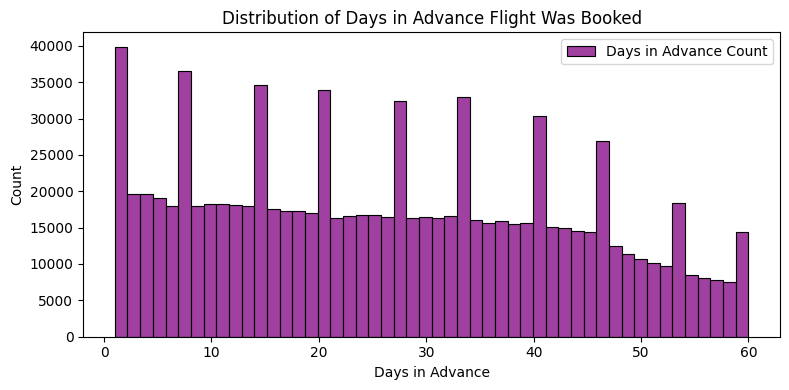

In [24]:
# Plot distribution of daysInAdvance
plt.figure(figsize=(8,4))
sns.histplot(df['daysInAdvance'] / (24*3600), bins=50, color='purple', label='Days in Advance Count')
plt.title('Distribution of Days in Advance Flight Was Booked')
plt.xlabel('Days in Advance')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

## Feature Selection: SelectKBest

In [27]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# set x and y
X = df_encoded.drop(columns = ['flightDate','totalFare'])
y = df_encoded['totalFare'].values

# construct SelectKBest constructor
kbest_selector = SelectKBest(score_func=mutual_info_regression, k=5)
kbest_selector.fit(X, y)

# extract cols with SelectKBest best score
kbest = kbest_selector.get_support()
top_features = X.columns[kbest]

print("Top features selected:")
print(top_features)

Top features selected:
Index(['travelDuration', 'totalTravelDistance', 'numStops', 'flightRouteCount',
       'flightsPerAirlineCount'],
      dtype='object')


### Principal Componenet Analysis

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


df_encoded = df_encoded.dropna()

# scale numerical data
scaler = StandardScaler()
X_num = df_encoded[num_features]
X_num_standard = scaler.fit_transform(X_num)

# subset categorical data and time data
df_cat_time_tmp = df_encoded.drop(columns=num_features)
X_cat = df_cat_time_tmp.drop(columns= ['flightDate','totalFare'])

# merge numerical, categorical and time data
# set x and y
X_all = np.hstack([X_num_standard, X_cat])
y = df_encoded['totalFare'].values

# apply pca, preserving 95% of variance
pca = PCA(n_components = 0.95,svd_solver='full', random_state= 42)
X_pca_sklearn = pca.fit_transform(X_all)


print(f"Explained Ratio: {sum(pca.explained_variance_ratio_)}")
print(f"Number of features before PCA {len(df_encoded.columns) - 1}")
print(f"Number of features after PCA {len(pca.components_)}")



Explained Ratio: 0.9504841171609938
Number of features before PCA 114
Number of features after PCA 44


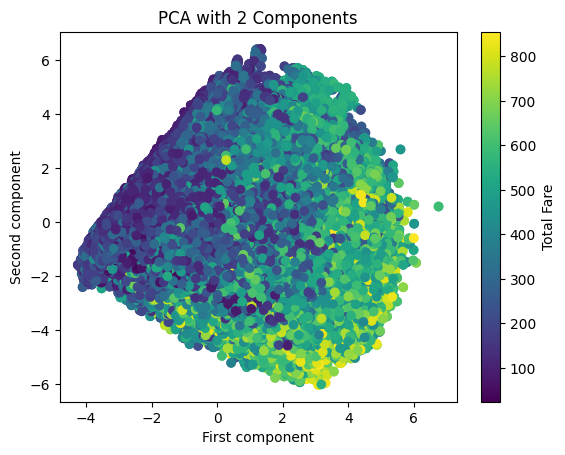

In [11]:
# plot data with 2 pca componenets

# scatter 1st and 2nd component
plt.scatter(X_pca_sklearn[:,0], X_pca_sklearn[:,1], c = y, cmap='viridis')
plt.scatter(X_pca_sklearn[:,0], X_pca_sklearn[:,1], c = y, cmap='viridis')

# set title and labels
plt.title('PCA with 2 Components')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.colorbar().set_label('Total Fare')
plt.show()

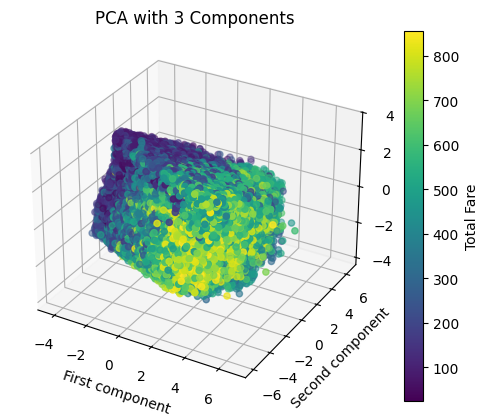

In [12]:
# plot data with 3 pca componenets
fig = plt.figure()

ax = fig.add_subplot(projection='3d')

# scatter 1st, 2nd, and 3rd component
scatter = ax.scatter(X_pca_sklearn[:,0],
                     X_pca_sklearn[:, 1],
                     X_pca_sklearn[:,2],
                     c = y, cmap='viridis')

# set title & labels
fig.colorbar(scatter, ax = ax, label= 'Total Fare')
ax.set_title('PCA with 3 Components')
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.set_zlabel('Third component')
plt.show()

## Linear Regression with SelectKBest

Traininng Time: 0.1379845142364502
R-squared: 0.32745130745187334
RMSE: 137.45018919551129
MAE: 109.9318530128747


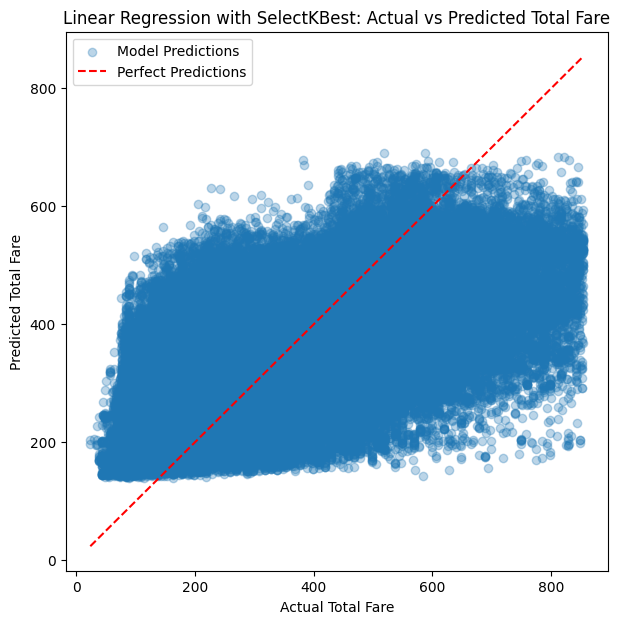

In [13]:
from sklearn.linear_model import LinearRegression

# set x with SelectKbest Features + flightsPerAirlineOnRouteSdCount and y
X = df_encoded.loc[:, ['travelDuration', 'totalTravelDistance', 'numStops', 'flightRouteCount', 'flightsPerAirlineCount', 'flightsPerAirlineOnRouteSdCount']].values
y = df_encoded['totalFare'].values

# split data 80% and 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# construct model
lr_1 = LinearRegression()

# log training and testing
start_time = time.time()
lr_1.fit(X_train, y_train)
end_time = time.time()
train_time = end_time - start_time

# eval on test data
y_pred = lr_1.predict(X_test)

# metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
mae = mean_absolute_error(y_test, y_pred)
print(f"Traininng Time: {train_time}")
print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# plot predicted vs actual val
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3, label = 'Model Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label = 'Perfect Predictions')
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')
plt.title('Linear Regression with SelectKBest: Actual vs Predicted Total Fare')
plt.legend()
plt.show()

## Linear Regression with PCA Components

Training Time: 2.941383123397827
R-squared: 0.5657090642523022
RMSE: 110.12628227328308
MAE: 86.44352560164629


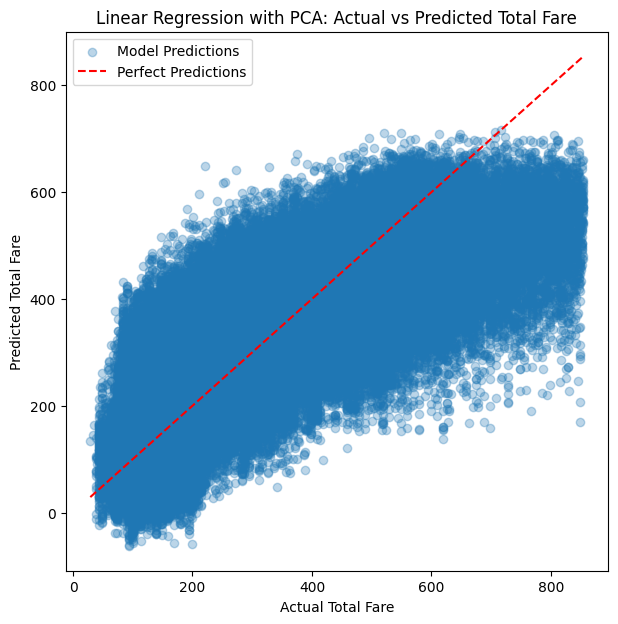

In [14]:
from sklearn.linear_model import LinearRegression

# set x as pca components and y
y = df_encoded['totalFare'].values

# split data 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X_pca_sklearn, y, test_size=0.2)

# construct model
lr_2 = LinearRegression()

# log training time
start_time = time.time()

# train model
lr_2.fit(X_train, y_train)
end_time = time.time()
train_time = end_time - start_time

# eval on test data
y_pred = lr_2.predict(X_test)

# metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
mae = mean_absolute_error(y_test, y_pred)

print(f"Training Time: {train_time}")
print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# plot predicted vs actual scores
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3, label = 'Model Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label = 'Perfect Predictions')
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')
plt.title('Linear Regression with PCA: Actual vs Predicted Total Fare')
plt.legend()
plt.show()

In [15]:
project.train_model(lr_2, X_pca_sklearn, y, 5)

Mean MAE: 86.48359168624427
STD MAE: 0.21722999310210345


## XGBoost with SelectKBest

Training Time: 55.404670000076294
R-squared: 0.6405103455135573
RMSE: 100.39766054013725
MAE: 74.07780768503271


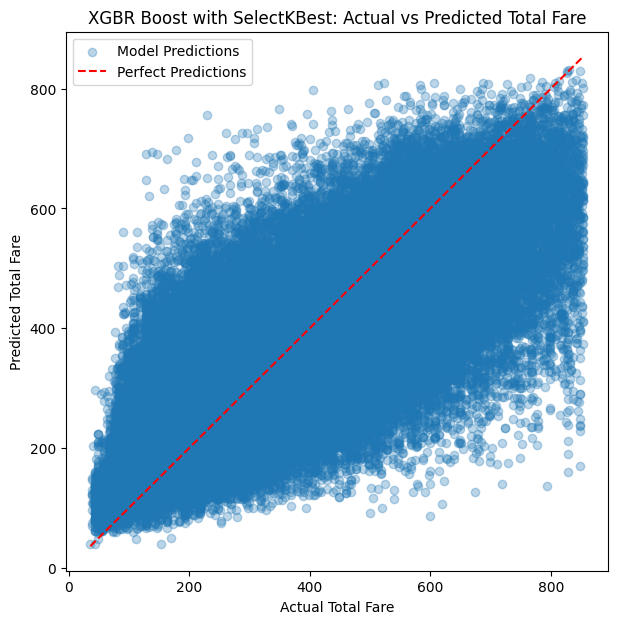

In [16]:
from xgboost import XGBRegressor
# set x and y
X = df_encoded.loc[:,['travelDuration', 'totalTravelDistance', 'numStops', 'flightRouteCount', 'flightsPerAirlineCount', 'flightsPerAirlineOnRouteSdCount']].values
y = df_encoded['totalFare'].values

# split data 80% test 20% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# construct model
xgbr_1 = XGBRegressor(
    n_estimators= 300,
    max_depth= 15,
    learning_rate=0.1,
    objective='reg:squarederror',
)

# log trainining time
start_time = time.time()
xgbr_1.fit(X_train, y_train)
end_time = time.time()
train_time = end_time - start_time

# eval on test data
y_pred = xgbr_1.predict(X_test)

# metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
mae = mean_absolute_error(y_test, y_pred)

print(f"Training Time: {train_time}")
print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# plot predicted vs actual vals
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3, label = 'Model Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label = 'Perfect Predictions')
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')
plt.title('XGBR Boost with SelectKBest: Actual vs Predicted Total Fare')
plt.legend()
plt.show()

## XGBoost with Complete Set of Features

Training Time: 189.0412347316742
R-squared: 0.8577449591112729
RMSE: 63.18446647844193
MAE: 44.3804704834664


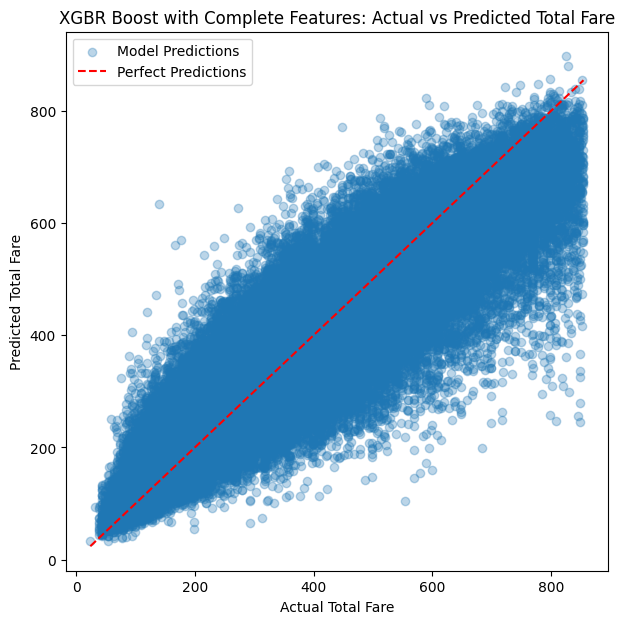

In [18]:
# set x and y
X = df_encoded.drop(columns = ['flightDate', 'totalFare'])
y = df_encoded['totalFare'].values

# split data 80% test 20% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# construct model
xgbr_2 = XGBRegressor(
    n_estimators= 300,
    max_depth= 15,
    learning_rate=0.1,
    objective='reg:squarederror',
)

# log training time
start_time = time.time()

# train model
xgbr_2.fit(X_train, y_train)

end_time = time.time()
train_time = end_time - start_time

# eval model on test data
y_pred = xgbr_2.predict(X_test)

# metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
mae = mean_absolute_error(y_test, y_pred)

print(f"Training Time: {train_time}")
print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# plot predicted vs actual vals
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3, label = 'Model Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label = 'Perfect Predictions')
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')
plt.title('XGBR Boost with Complete Features: Actual vs Predicted Total Fare')
plt.legend()
plt.show()

In [20]:
X = df_encoded.drop(columns = ['flightDate', 'totalFare'])

# eval model avg and std mae when split/run 5 times
project.train_model(xgbr_2, X, y, 5)

Mean MAE: 44.48421828350651
STD MAE: 0.11126345754894923


## Random Forest

In [3]:
from sklearn.ensemble import RandomForestRegressor

# set x and y
X = df_encoded.drop(columns =  ['flightDate','totalFare'])
y = df_encoded['totalFare'].values

# split data 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# construct model
rf_1 = RandomForestRegressor(n_estimators=100)

# log training time
start_time = time.time()

# train model
rf_1.fit(X_train, y_train)
end_time = time.time()
train_time = end_time - start_time


Training Time: 2260.6388535499573
R-squared: 0.835946108232994
RMSE: 67.9266780242741
MAE: 47.22983240479746


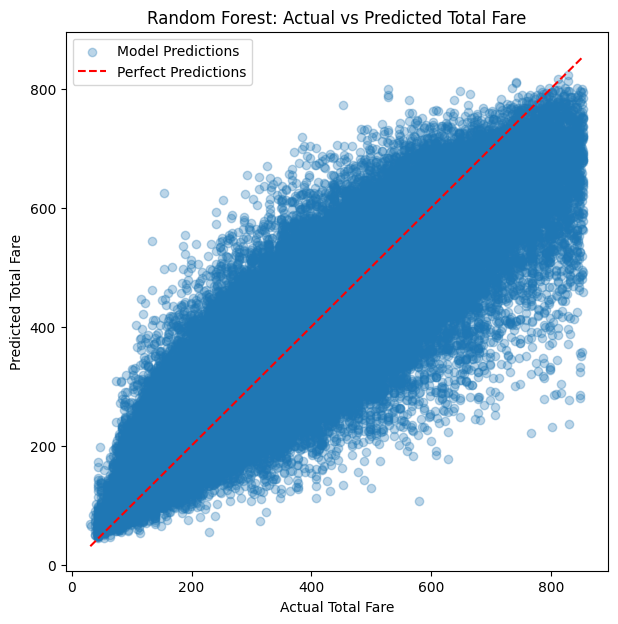

In [15]:
# eval model on test data
y_pred = rf_1.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
mae = mean_absolute_error(y_test, y_pred)

print(f"Training Time: {train_time}")
print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# plot predicted vs actual value
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3, label = 'Model Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label = 'Perfect Predictions')
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')
plt.title('Random Forest: Actual vs Predicted Total Fare')
plt.legend()
plt.show()

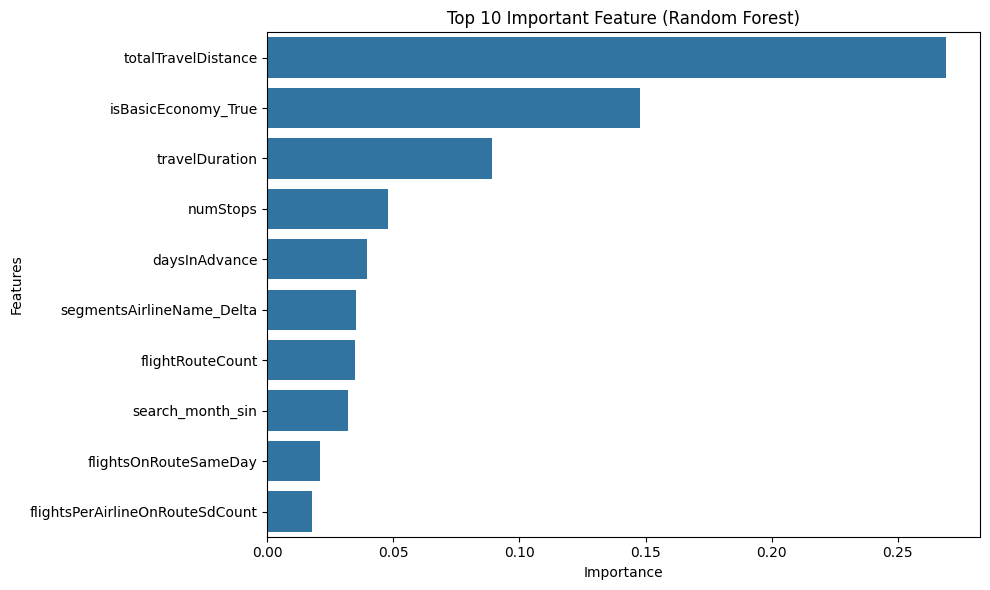

In [21]:
# plot important features by random forest
importances = rf_1.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns.to_list(),
                                      'importance': importances}).sort_values(by='importance', ascending=False)

# take only top 10 features
top_10 = feature_importance_df.head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y = 'feature', data=top_10)
plt.title('Top 10 Important Feature (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


## Neural Network with PCA

In [14]:
from tensorflow.keras import layers
import tensorflow as tf

# split data 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X_pca_sklearn, y, test_size=0.25)

# construct model
model_1 = tf.keras.models.Sequential([

    layers.Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer='he_normal'),
    layers.Dense(512,activation='relu'),
    layers.Dense(256,  activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

start_time = time.time()

# complie model
model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# record scores
history_1 = model_1.fit(X_train, y_train, epochs= 10, batch_size= 64, validation_data=(X_test, y_test))
end_time = time.time()
train_time = end_time - start_time
print(f"Training Time: {train_time}")

# eval on test data
model_1.evaluate(X_test, y_test)

Epoch 1/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 220s 21ms/step - loss: 15033.1953 - mae: 87.3947 - val_loss: 7767.0620 - val_mae: 66.7546
Epoch 2/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 211s 20ms/step - loss: 7459.3208 - mae: 64.6795 - val_loss: 6914.6494 - val_mae: 61.9987
Epoch 3/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 264s 20ms/step - loss: 6763.3833 - mae: 61.1026 - val_loss: 6627.2363 - val_mae: 60.1800
Epoch 4/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 262s 20ms/step - loss: 6369.4478 - mae: 58.9785 - val_loss: 6261.3618 - val_mae: 58.0439
Epoch 5/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 208s 20ms/step - loss: 6057.3906 - mae: 57.3504 - val_loss: 6218.5640 - val_mae: 57.1724
Epoch 6/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 266s 20ms/step - loss: 5797.7031 - mae: 55.9303 - val_loss: 5966.0215 - val_mae: 56.2956
Epoch 7/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 256s 20ms/step - loss: 5556.6636 - mae: 54.6056 - val_loss: 5878.1987 - val_mae: 56.4889
Epoch 8/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 269s 20ms/step - loss: 5

[5898.59033203125, 56.8685417175293]

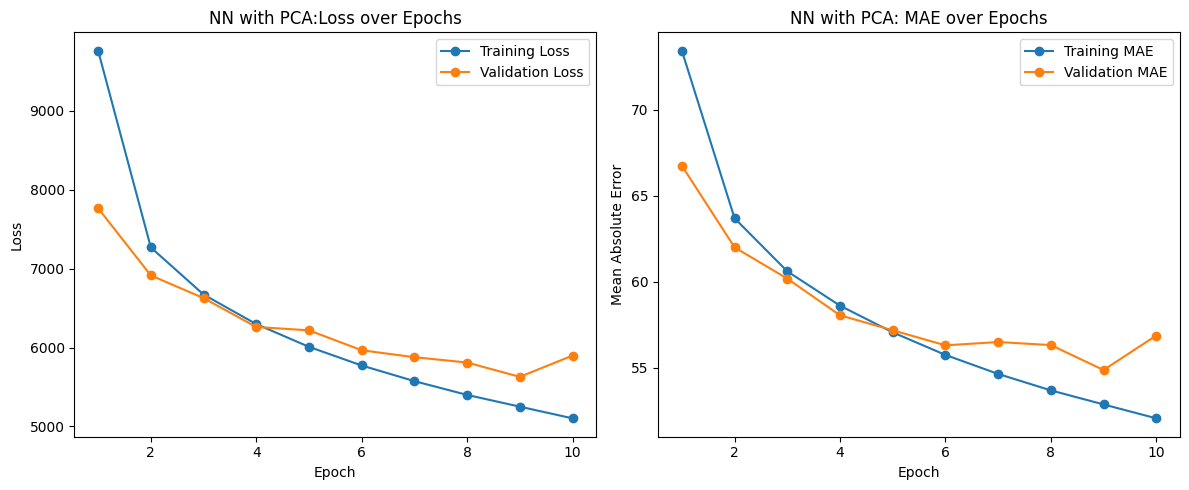

In [23]:
# plot mse loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,11),history_1.history['loss'], label='Training Loss', marker='o')
plt.plot(range(1,11),history_1.history['val_loss'], label='Validation Loss', marker='o')
plt.title('NN with PCA:Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plos mae over epochs
plt.subplot(1, 2, 2)
plt.plot(range(1,11),history_1.history['mae'], label='Training MAE', marker='o')
plt.plot(range(1,11),history_1.history['val_mae'], label='Validation MAE', marker='o')
plt.title('NN with PCA: MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


## Neural Network with Complete Set of Features

In [13]:
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# scale numerical features
scaler = StandardScaler()
X_num = df_encoded[num_features]
X_num_standard = scaler.fit_transform(X_num)

# subset bools to be converted to 0,1
# exclude time and numerical
X_cat_df_temp = df_encoded.drop(columns= time_data + num_features)
X_cat_df_temp = X_cat_df_temp.drop(columns= ['flightDate','totalFare'])
X_cat = X_cat_df_temp.astype(bool)

# subset time data
X_time = df_encoded[time_data]

# merge time, numeric, and categorical data
X_all = np.hstack([X_num_standard, X_cat, X_time])
y = df_encoded['totalFare'].values

# split data 75% train 25% test
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.25)

# create model
model_2 = tf.keras.models.Sequential([
    layers.Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer='he_normal'),
    layers.Dense(512,activation='relu'),
    layers.Dense(256,  activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

start_time = time.time()

# compile model
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# record scores
history_2 = model_2.fit(X_train, y_train, epochs= 10, batch_size= 64, validation_data=(X_test, y_test))

end_time = time.time()
train_time = end_time - start_time
print(f"Training Time: {train_time}")

# eval on test data
model_2.evaluate(X_test, y_test)

Epoch 1/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 363s 34ms/step - loss: 14975.8730 - mae: 86.0871 - val_loss: 7080.7300 - val_mae: 63.7758
Epoch 2/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 383s 34ms/step - loss: 6812.2920 - mae: 61.6929 - val_loss: 6345.0181 - val_mae: 59.4033
Epoch 3/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 323s 29ms/step - loss: 6198.1670 - mae: 58.4709 - val_loss: 5969.7588 - val_mae: 56.9312
Epoch 4/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 244s 21ms/step - loss: 5815.2964 - mae: 56.3103 - val_loss: 6035.1050 - val_mae: 58.1447
Epoch 5/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 261s 21ms/step - loss: 5538.6855 - mae: 54.7922 - val_loss: 5560.3940 - val_mae: 54.5130
Epoch 6/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 244s 23ms/step - loss: 5341.0522 - mae: 53.6557 - val_loss: 5440.9624 - val_mae: 54.5588
Epoch 7/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 329s 30ms/step - loss: 5129.7954 - mae: 52.4954 - val_loss: 5636.7402 - val_mae: 54.0903
Epoch 8/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 267s 24ms/step - loss: 4

[5043.115234375, 51.45793914794922]

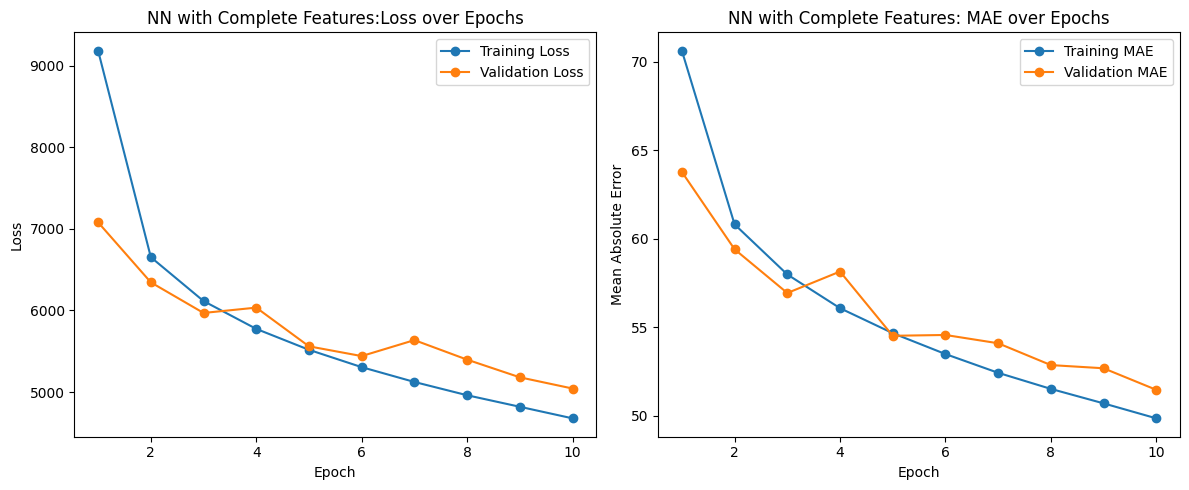

In [15]:
# plot mse loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,11),history_2.history['loss'], label='Training Loss', marker='o')
plt.plot(range(1,11),history_2.history['val_loss'], label='Validation Loss', marker='o')
plt.title('NN with Complete Features:Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plos mae over epochs
plt.subplot(1, 2, 2)
plt.plot(range(1,11),history_2.history['mae'], label='Training MAE', marker='o')
plt.plot(range(1,11),history_2.history['val_mae'], label='Validation MAE', marker='o')
plt.title('NN with Complete Features: MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
model_2_avg = np.zeros(3)
model_2_std = np.zeros(3)

# split, construct, and fit model 3 times
for i in range(3):

    # split data 75% train 25% test
    X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.25)

    # construct model_2
    model_2 = tf.keras.models.Sequential([
    layers.Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer='he_normal'),
    layers.Dense(512,activation='relu'),
    layers.Dense(256,  activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
    ])

    # select bacth size 64
    m_2 = project.train_NN_model(model_2, X_train, y_train, X_test, y_test)

    # record average test accuracy
    model_2_avg[i] = np.mean(m_2.history['val_mae'])

    # record standard deviation
    model_2_std[i] = np.std(m_2.history['val_mae'])


Epoch 1/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 228s 21ms/step - loss: 15140.6875 - mae: 86.4903 - val_loss: 7156.4126 - val_mae: 62.2377
Epoch 2/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 273s 22ms/step - loss: 6732.3726 - mae: 61.2849 - val_loss: 6398.7603 - val_mae: 58.5012
Epoch 3/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 246s 21ms/step - loss: 6140.0488 - mae: 58.1853 - val_loss: 6161.4492 - val_mae: 57.1760
Epoch 4/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 264s 21ms/step - loss: 5774.8330 - mae: 56.1431 - val_loss: 5781.2280 - val_mae: 56.1627
Epoch 5/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 260s 21ms/step - loss: 5505.2920 - mae: 54.6026 - val_loss: 5709.2227 - val_mae: 54.5850
Epoch 6/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 265s 21ms/step - loss: 5269.7104 - mae: 53.2914 - val_loss: 5410.3267 - val_mae: 53.8402
Epoch 7/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 256s 21ms/step - loss: 5050.7534 - mae: 52.1069 - val_loss: 5382.5762 - val_mae: 53.8419
Epoch 8/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 267s 21ms/step - loss: 4

In [30]:
# display results
print(f"Mean Val MAE Over each Epoch:")
print(f"First Run: {model_2_avg[0]} ")
print(f"Second Run: {model_2_avg[1]} ")
print(f"Third Run: {model_2_avg[2]} ")
print("")
print(f"Val MAE Std Over each Epoch:")
print(f"First Run: {model_2_std[0]} ")
print(f"Second Run: {model_2_std[1]} ")
print(f"Third Run: {model_2_std[2]} ")
print("")
print(f"Overall Mean Val MAE: {np.mean(model_2_avg)}")
print(f"Overal Val MAE Std: {np.mean(model_2_std)}")


Mean Val MAE Over each Epoch:
First Run: 55.222680282592776 
Second Run: 55.72625999450683 
Third Run: 55.615667724609374 

Val MAE Std Over each Epoch:
First Run: 3.1820289255393077 
Second Run: 3.4430987356244303 
Third Run: 3.161867644710806 

Overall Mean Val MAE: 55.52153600056966
Overal Val MAE Std: 3.2623317686248483
